## Build an MTH5 and Operate the Aurora Pipeline

This notebook pulls MT miniSEED data from the IRIS Dataselect web service and produces MTH5 out of it. It outlines the process of making an MTH5 file, generating a processing config, and running the Aurora processor.

It assumes that aurora, mth5, and mt_metadata have all been installed.

In [1]:
# Required imports for theh program. 
from pathlib import Path
import sys
import pandas as pd
import mth5
from mth5.clients.make_mth5 import MakeMTH5
from mth5 import mth5, timeseries
from mt_metadata.utils.mttime import get_now_utc, MTime
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5_run

2022-05-20 16:02:33,136 [line 135] mth5.setup_logger - INFO: Logging file can be found /Users/laura/IRIS_TOOLS/AURORA/mth5/logs/mth5_debug.log


### Set up MTH5 object and retrieve data
To build an MTH5 file with data extracted from IRIS, first initialize an MTH5 object that will be used to grab the requested data from the specified client. We create a dataframe of the targets and time frames of the desired data, which is then passed along to the MTH5 object.

In [2]:
# Set path so MTH5 file builds to current working directory. 
default_path = Path().cwd()

In [3]:
# Initialize the Make MTH5 code. 
m = MakeMTH5(mth5_version='0.1.0')
m.client = "IRIS"

In [4]:
# Generate data frame of FDSN Network, Station, Location, Channel, Startime, Endtime codes of interest

ZUCAS04LQ1 = ['8P', 'CAS04', '', 'LQE', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
ZUCAS04LQ2 = ['8P', 'CAS04', '', 'LQN', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
ZUCAS04BF1 = ['8P', 'CAS04', '', 'LFE', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
ZUCAS04BF2 = ['8P', 'CAS04', '', 'LFN', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
ZUCAS04BF3 = ['8P', 'CAS04', '', 'LFZ', '2020-06-02T19:00:00', '2020-07-13T19:00:00']

request_list = [ZUCAS04LQ1, ZUCAS04LQ2, ZUCAS04BF1, ZUCAS04BF2, ZUCAS04BF3]

# Turn list into dataframe
request_df =  pd.DataFrame(request_list, columns=m.column_names)

In [5]:
# Inspect the dataframe
print(request_df)

  network station location channel                start                  end
0      8P   CAS04              LQE  2020-06-02T19:00:00  2020-07-13T19:00:00
1      8P   CAS04              LQN  2020-06-02T19:00:00  2020-07-13T19:00:00
2      8P   CAS04              LFE  2020-06-02T19:00:00  2020-07-13T19:00:00
3      8P   CAS04              LFN  2020-06-02T19:00:00  2020-07-13T19:00:00
4      8P   CAS04              LFZ  2020-06-02T19:00:00  2020-07-13T19:00:00


You can view the inventory of the targets and timespans that the client (IRIS, in this case) has available. data=False will display just the metadata and is quicker, data=True will also request information about the data extents that are available.  

In [6]:
# Request the inventory information from IRIS
inventory = m.get_inventory_from_df(request_df, data=False)

In [7]:
# Inspect the inventory
inventory

(Inventory created at 2022-05-20T23:02:34.878618Z
	Created by: ObsPy 1.2.2
		    https://www.obspy.org
	Sending institution: MTH5
	Contains:
		Networks (1):
			8P
		Stations (1):
			8P.CAS04 (Corral Hollow, CA, USA)
		Channels (5):
			8P.CAS04..LFZ, 8P.CAS04..LFN, 8P.CAS04..LFE, 8P.CAS04..LQN, 
			8P.CAS04..LQE,
 0 Trace(s) in Stream:
)

With the mth5 object set, we are ready to actually request the data from the fdsn client (IRIS) and save it to an MTH5 file.  This process builds an MTH5 file and can take some time depending on how much data is requested.  

Note: interact keeps the MTH5 open after it is done building


In [8]:
mth5_object = m.make_mth5_from_fdsnclient(request_df, interact=True)

2022-05-20 16:02:35,585 [line 590] mth5.mth5.MTH5.open_mth5 - WARNING: 8P_CAS04.h5 will be overwritten in 'w' mode
2022-05-20 16:02:36,370 [line 655] mth5.mth5.MTH5._initialize_file - INFO: Initialized MTH5 0.1.0 file /Users/laura/IRIS_TOOLS/AURORA/aurora/docs/notebooks/8P_CAS04.h5 in mode w
2022-05-20 16:03:01,376 [line 120] mt_metadata.base.metadata.station.add_run - WARNING: Run a is being overwritten with current information


2022-05-20T16:03:01 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-05-20T16:03:01 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter
2022-05-20T16:03:01 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-05-20T16:03:01 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter
More or less runs have been requested by the user than are defined in the metadata. Runs will be defined but only the requested run extents contain time series data based on the users request.


2022-05-20 16:03:07,420 [line 224] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: start time of dataset 2020-06-02T19:00:00+00:00 does not match metadata start 2020-06-02T18:41:43+00:00 updating metatdata value to 2020-06-02T19:00:00+00:00
2022-05-20 16:04:02,823 [line 462] mth5.timeseries.run_ts.RunTS.from_obspy_stream - WARNING: could not find ey
2022-05-20 16:04:39,212 [line 462] mth5.timeseries.run_ts.RunTS.from_obspy_stream - WARNING: could not find ex
2022-05-20 16:04:39,427 [line 462] mth5.timeseries.run_ts.RunTS.from_obspy_stream - WARNING: could not find ey
2022-05-20 16:04:40,421 [line 235] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2020-07-13T19:00:00+00:00 does not match metadata end 2020-07-13T21:46:12+00:00 updating metatdata value to 2020-07-13T19:00:00+00:00


In [9]:
# mth5_object.open_mth5(h5_path, 'w')
# h5_path = str(default_path)+'/8P_CAS04.h5'
#mth5_object.close_mth5()

### Examine and Update the MTH5 object

With the open MTH5 Object, we can start to examine what is in it. For example, we retrieve the filename and file_version. You can additionally do things such as getting the station information and edit it by setting a new value, in this case the declination model. 

In [10]:
mth5_object

/:
    |- Group: Survey
    ----------------
        |- Group: Filters
        -----------------
            |- Group: coefficient
            ---------------------
                |- Group: electric_analog_to_digital
                ------------------------------------
                |- Group: electric_dipole_92.000
                --------------------------------
                |- Group: electric_si_units
                ---------------------------
                |- Group: magnetic_analog_to_digital
                ------------------------------------
            |- Group: fap
            -------------
            |- Group: fir
            -------------
            |- Group: time_delay
            --------------------
                |- Group: electric_time_offset
                ------------------------------
                |- Group: hx_time_offset
                ------------------------
                |- Group: hy_time_offset
                ------------------------
         

In [11]:
# Collect information from the MTh5 Object and use it in the config files. 
mth5_filename = mth5_object.filename
version = mth5_object.file_version
print(mth5_filename)

/Users/laura/IRIS_TOOLS/AURORA/aurora/docs/notebooks/8P_CAS04.h5


In [12]:
# Edit and update the MTH5 metadata 
s = mth5_object.get_station("CAS04")
print(s.metadata.location.declination.model)
s.metadata.location.declination.model = 'IGRF'
print(s.metadata.location.declination.model)
s.write_metadata()    # writes to file mth5_filename

IGRF-13
IGRF


Now we look more closely at the metadata. Start by calling .summarize() to initialize the channel_summary if we have not yet closed the mth5 object (we have not).  Then by calling .to_dataframe() we can start calling on attributes such as run or sample_rate. 

In [13]:
# Get the available stations and runs from the MTH5 object
mth5_object.channel_summary.summarize()
ch_summary = mth5_object.channel_summary.to_dataframe()

In [14]:
ch_summary

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,ey,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hy,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hz,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
5,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,ex,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
6,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,ey,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
7,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hx,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
8,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hy,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
9,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hz,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


In [15]:
available_runs = ch_summary.run.unique()
sr = ch_summary.sample_rate.unique()
if len(sr) != 1:
    print('Only one sample rate per run is available')
available_stations = ch_summary.station.unique()

In [16]:
sr[0]

1.0

In [17]:
available_stations[0]

'CAS04'

In [18]:
mth5_object

/:
    |- Group: Survey
    ----------------
        |- Group: Filters
        -----------------
            |- Group: coefficient
            ---------------------
                |- Group: electric_analog_to_digital
                ------------------------------------
                |- Group: electric_dipole_92.000
                --------------------------------
                |- Group: electric_si_units
                ---------------------------
                |- Group: magnetic_analog_to_digital
                ------------------------------------
            |- Group: fap
            -------------
            |- Group: fir
            -------------
            |- Group: time_delay
            --------------------
                |- Group: electric_time_offset
                ------------------------------
                |- Group: hx_time_offset
                ------------------------
                |- Group: hy_time_offset
                ------------------------
         

### Generate an Aurora Configuration file using MTH5 as an input

Up to this point, we have used mth5 and mt_metadata, but haven't yet used aurora. So we will use the MTH5 that we just created (and examined and updated) as input into Aurora.

First, we get some fields from the MTH5 and input those into an aurora Configuration file and then save that json file.

In [19]:
station_id = available_stations[0]
run_id = available_runs[0]
sample_rate = sr[0]
config_maker = ConfigCreator()
config_path = config_maker.create_run_config(station_id, run_id, mth5_filename, sample_rate)


In [20]:
config_path

PosixPath('config/CAS04-a_run_config.json')

Run the Aurora Pipeline using the input MTH5 and Confiugration File, outputting transfer functions.

In [21]:
show_plot='True'   # change to 'False' to omit plots

config indicates 4 decimation levels to process: [0, 1, 2, 3]


/Users/laura/IRIS_TOOLS/AURORA/aurora/aurora/pipelines/time_series_helpers.py:192: RuntimeWarning: invalid value encountered in true_divide
  stft_obj[channel_id].data /= calibration_response


/Users/laura/IRIS_TOOLS/AURORA/aurora/aurora/config/emtf_band_setup/bs_test.cfg
Processing band 25.728968s
Processing band 19.929573s
Processing band 15.164131s
Processing band 11.746086s
Processing band 9.195791s
Processing band 7.362526s
Processing band 5.856115s
Processing band 4.682492s
GET PLOTTER FROM MTpy
OK, now ser linewidth and markersize


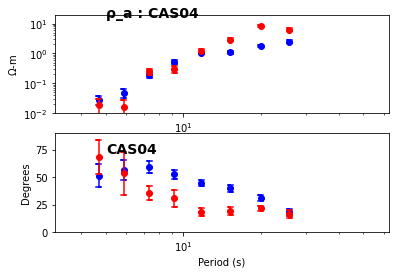

/Users/laura/IRIS_TOOLS/AURORA/aurora/aurora/pipelines/time_series_helpers.py:192: RuntimeWarning: invalid value encountered in true_divide
  stft_obj[channel_id].data /= calibration_response


/Users/laura/IRIS_TOOLS/AURORA/aurora/aurora/config/emtf_band_setup/bs_test.cfg
Processing band 102.915872s
Processing band 85.631182s
Processing band 68.881694s
Processing band 54.195827s
Processing band 43.003958s
Processing band 33.310722s
GET PLOTTER FROM MTpy
OK, now ser linewidth and markersize


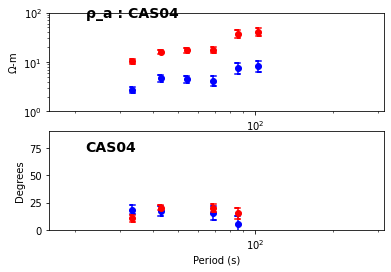

/Users/laura/IRIS_TOOLS/AURORA/aurora/aurora/pipelines/time_series_helpers.py:192: RuntimeWarning: invalid value encountered in true_divide
  stft_obj[channel_id].data /= calibration_response


/Users/laura/IRIS_TOOLS/AURORA/aurora/aurora/config/emtf_band_setup/bs_test.cfg
Processing band 411.663489s
Processing band 342.524727s
Processing band 275.526776s
Processing band 216.783308s
Processing band 172.015831s
Processing band 133.242890s
GET PLOTTER FROM MTpy
OK, now ser linewidth and markersize


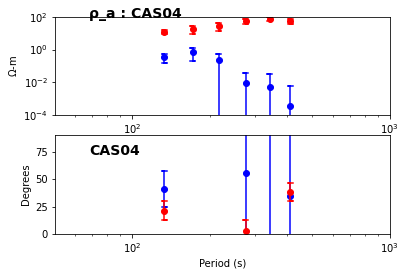

/Users/laura/IRIS_TOOLS/AURORA/aurora/aurora/pipelines/time_series_helpers.py:192: RuntimeWarning: invalid value encountered in true_divide
  stft_obj[channel_id].data /= calibration_response


/Users/laura/IRIS_TOOLS/AURORA/aurora/aurora/config/emtf_band_setup/bs_test.cfg
Processing band 1514.701336s
WARNING - Negative error variances observed
[ 0.]
Setting residual_variance to zero - Negative values observed
WARNING - Negative error variances observed
[ 0.]
Setting residual_variance to zero - Negative values observed
WARNING - Negative error variances observed
[ -8.73114914e-11]
Setting residual_variance to zero - Negative values observed
WARNING - Negative error variances observed
[ 0.]
Setting residual_variance to zero - Negative values observed
WARNING - Negative error variances observed
[ 0.]
Setting residual_variance to zero - Negative values observed
WARNING - Negative error variances observed
[ 0.]
Setting residual_variance to zero - Negative values observed
Processing band 1042.488956s


/Users/laura/IRIS_TOOLS/AURORA/aurora/aurora/transfer_function/regression/m_estimator.py:270: RuntimeWarning: divide by zero encountered in true_divide
  r = np.abs(self.Y[:, k] - self.Y_hat[:, k]) / sigma
/Users/laura/IRIS_TOOLS/AURORA/aurora/aurora/transfer_function/regression/m_estimator.py:279: RuntimeWarning: invalid value encountered in multiply
  t = w * (1 + t)
/Users/laura/IRIS_TOOLS/AURORA/aurora/aurora/transfer_function/regression/m_estimator.py:334: RuntimeWarning: divide by zero encountered in true_divide
  cov_nn = inv_psi_prime2 @ SSR_clean / self.degrees_of_freedom
/Users/laura/IRIS_TOOLS/AURORA/aurora/aurora/transfer_function/regression/m_estimator.py:334: RuntimeWarning: invalid value encountered in true_divide
  cov_nn = inv_psi_prime2 @ SSR_clean / self.degrees_of_freedom
/Users/laura/IRIS_TOOLS/AURORA/aurora/aurora/transfer_function/regression/m_estimator.py:334: RuntimeWarning: divide by zero encountered in true_divide
  cov_nn = inv_psi_prime2 @ SSR_clean / self.

Processing band 723.371271s
Processing band 532.971560s
Processing band 412.837995s
GET PLOTTER FROM MTpy
OK, now ser linewidth and markersize


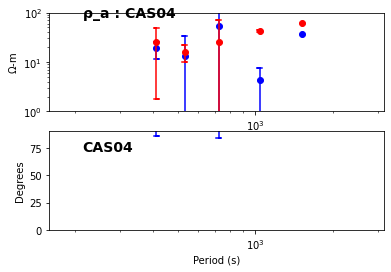

['a']


/Users/laura/IRIS_TOOLS/AURORA/mt_metadata/mt_metadata/transfer_functions/core.py:828: RuntimeWarning: invalid value encountered in multiply
  sigma_e.loc[dict(input=["ex"], output=["ex"])].data.flatten()
/Users/laura/IRIS_TOOLS/AURORA/mt_metadata/mt_metadata/transfer_functions/core.py:832: RuntimeWarning: invalid value encountered in multiply
  sigma_e.loc[dict(input=["ex"], output=["ex"])].data.flatten()
/Users/laura/IRIS_TOOLS/AURORA/mt_metadata/mt_metadata/transfer_functions/core.py:836: RuntimeWarning: invalid value encountered in multiply
  sigma_e.loc[dict(input=["ey"], output=["ey"])].data.flatten()
/Users/laura/IRIS_TOOLS/AURORA/mt_metadata/mt_metadata/transfer_functions/core.py:840: RuntimeWarning: invalid value encountered in multiply
  sigma_e.loc[dict(input=["ey"], output=["ey"])].data.flatten()
/Users/laura/IRIS_TOOLS/AURORA/mt_metadata/mt_metadata/transfer_functions/core.py:870: RuntimeWarning: invalid value encountered in multiply
  sigma_e.loc[dict(input=["hz"], output

In [22]:
tf_cls = process_mth5_run(
        config_path,
        run_id,
        mth5_path=mth5_filename,
        units="MT",
        show_plot=show_plot,
        z_file_path=None,
        return_collection=False,
    )

In [23]:
type(tf_cls)

mt_metadata.transfer_functions.core.TF

Write the transfer functions generated by the Aurora pipeline, showing examples of various output formats.

In [24]:
tf_cls.write_tf_file(fn="emtfxml_test.xml", file_type="emtfxml")

2022-05-20 16:05:57,711 [line 197] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote emtfxml_test.xml


EMTFXML(station='CAS04', latitude=37.63, longitude=-121.47, elevation=329.39)

In [25]:
tf_cls.write_tf_file(fn="edi_test.edi", file_type="edi")

2022-05-20 16:05:58,177 [line 328] mt_metadata.base.metadata.define_measurement.write_measurement - INFO: No XMEAS information.
2022-05-20 16:05:58,185 [line 197] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote edi_test.edi
2022-05-20 16:05:58,286 [line 133] mt_metadata.base.metadata.run.add_channel - ERROR: component cannot be empty


ValueError: component cannot be empty

In [26]:
tf_cls.write_tf_file(fn="zmm_test.zmm", file_type="zmm")

2022-05-20 16:06:01,208 [line 232] mt_metadata.transfer_functions.io.zfiles.zmm.ZMM.write_header - WARNING: Could not find hx
2022-05-20 16:06:01,212 [line 232] mt_metadata.transfer_functions.io.zfiles.zmm.ZMM.write_header - WARNING: Could not find hy
2022-05-20 16:06:01,217 [line 232] mt_metadata.transfer_functions.io.zfiles.zmm.ZMM.write_header - WARNING: Could not find hz
2022-05-20 16:06:01,220 [line 232] mt_metadata.transfer_functions.io.zfiles.zmm.ZMM.write_header - WARNING: Could not find ex
2022-05-20 16:06:01,226 [line 232] mt_metadata.transfer_functions.io.zfiles.zmm.ZMM.write_header - WARNING: Could not find ey
2022-05-20 16:06:01,254 [line 197] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote zmm_test.zmm


MT( station='CAS04', latitude=37.63, longitude=-121.47, elevation=329.39 )